In [1]:
%matplotlib inline
import os
import gc
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import callbacks
from keras.optimizers import Adam
from keras.models import Sequential
from keras.utils import normalize,to_categorical
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.layers import BatchNormalization,Conv2D,MaxPool2D,Flatten,Dense,Dropout 
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array, array_to_img
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split
import warnings
warnings.filterwarnings('ignore')
print(os.listdir("/Users/susovan/Desktop/springboard doc/ship dataset"))



/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


['.DS_Store', 'train', 'test_ApKoW4T.csv', 'sample_submission_ns2btKE.csv']


In [2]:
# the path for loading .jpg images
path = "/Users/susovan/Desktop/springboard doc/ship dataset/train/images"

train_files = pd.read_csv('/Users/susovan/Desktop/springboard doc/ship dataset/train/train.csv', 
                          dtype={'image': 'object', 'category': 'int8'})

test_files = pd.read_csv('/Users/susovan/Desktop/springboard doc/ship dataset/test_ApKoW4T.csv')

In [3]:
train_files

image  category
0     2823080.jpg         1
1     2870024.jpg         1
2     2662125.jpg         2
3     2900420.jpg         3
4     2804883.jpg         2
...           ...       ...
6247  2881056.jpg         3
6248  1145083.jpg         2
6249  2898652.jpg         5
6250  2868175.jpg         3
6251  2784171.jpg         1

[6252 rows x 2 columns]

In [4]:
train_files.dtypes

image       object
category      int8
dtype: object

In [5]:
test_files.head()

image
0  1007700.jpg
1  1011369.jpg
2  1051155.jpg
3  1062001.jpg
4  1069397.jpg

In [6]:
# display missing categories in train
train_files[train_files.isnull().any(axis=1)]

Empty DataFrame
Columns: [image, category]
Index: []

In [7]:
# dictionary ship encoding 
ship = {'Cargo': 1, 
        'Military': 2, 
        'Carrier': 3, 
        'Cruise': 4, 
        'Tankers': 5}

# reverse the ship type dictionary
ship = dict([[v,k] for k,v in ship.items()])
ship

{1: 'Cargo', 2: 'Military', 3: 'Carrier', 4: 'Cruise', 5: 'Tankers'}

In [8]:
# Create test labels for interpretability
train_files['ship'] = train_files['category'].map(ship).astype('category')
print(train_files)
labels = list(train_files['ship'].unique())
labels

            image  category      ship
0     2823080.jpg         1     Cargo
1     2870024.jpg         1     Cargo
2     2662125.jpg         2  Military
3     2900420.jpg         3   Carrier
4     2804883.jpg         2  Military
...           ...       ...       ...
6247  2881056.jpg         3   Carrier
6248  1145083.jpg         2  Military
6249  2898652.jpg         5   Tankers
6250  2868175.jpg         3   Carrier
6251  2784171.jpg         1     Cargo

[6252 rows x 3 columns]


['Cargo', 'Military', 'Carrier', 'Cruise', 'Tankers']

In [9]:
# display count of ship types
plt.title('Count of each ship type')
sns.countplot(y=train_files['ship'].values)
plt.show()


In [10]:
a=train_files['ship'].value_counts(normalize=False)
a

Cargo       2120
Tankers     1217
Military    1167
Carrier      916
Cruise       832
Name: ship, dtype: int64

In [11]:
train_files['ship'].value_counts(normalize=True)

Cargo       0.339091
Tankers     0.194658
Military    0.186660
Carrier     0.146513
Cruise      0.133077
Name: ship, dtype: float64

In [12]:
#import random
#train_cargo = ["/Users/susovan/Desktop/springboard doc/ship dataset/train/images/".format(i) for i in train_files['ship'] if 'Cargo' in i]
#train_tankers = ["/Users/susovan/Desktop/springboard doc/ship dataset/train/images".format(i) for i in train_files['ship'] if i in 'Tankers']
#train_img = train_cargo[:1000] + train_tankers[:1000]
#random.shuffle(train_img)
#for i in train_img:
    #plt.imshow(train_img[i])
#plt.show()
#train_cargo

In [13]:

def load(what='train', target_size=(120,120)):
    array = []
    if what =='train':
        for file in tqdm(train_files['image'].values):
            img = load_img(os.path.join(path, file), target_size=target_size)
            img = img_to_array(img)/255. # normalize image tensor
            array.append(img)
    elif what =='test':
        for file in tqdm(test_files['image'].values):
            img = load_img(os.path.join(path, file), target_size=target_size)
            img = img_to_array(img)/255. # normalize image tensor
            array.append(img)
    gc.collect()
    return np.asarray(array)

In [14]:
# Load Train and Test
X_train = load()
test = load('test')
print(f'train dtype: {X_train.dtype}')
print(f'test dtype: {test.dtype}')
print(f'train shape: {X_train.shape}')

100%|██████████| 2680/2680 [00:03<00:00, 833.06it/s]


train dtype: float32
test dtype: float32
train shape: (6252, 120, 120, 3)


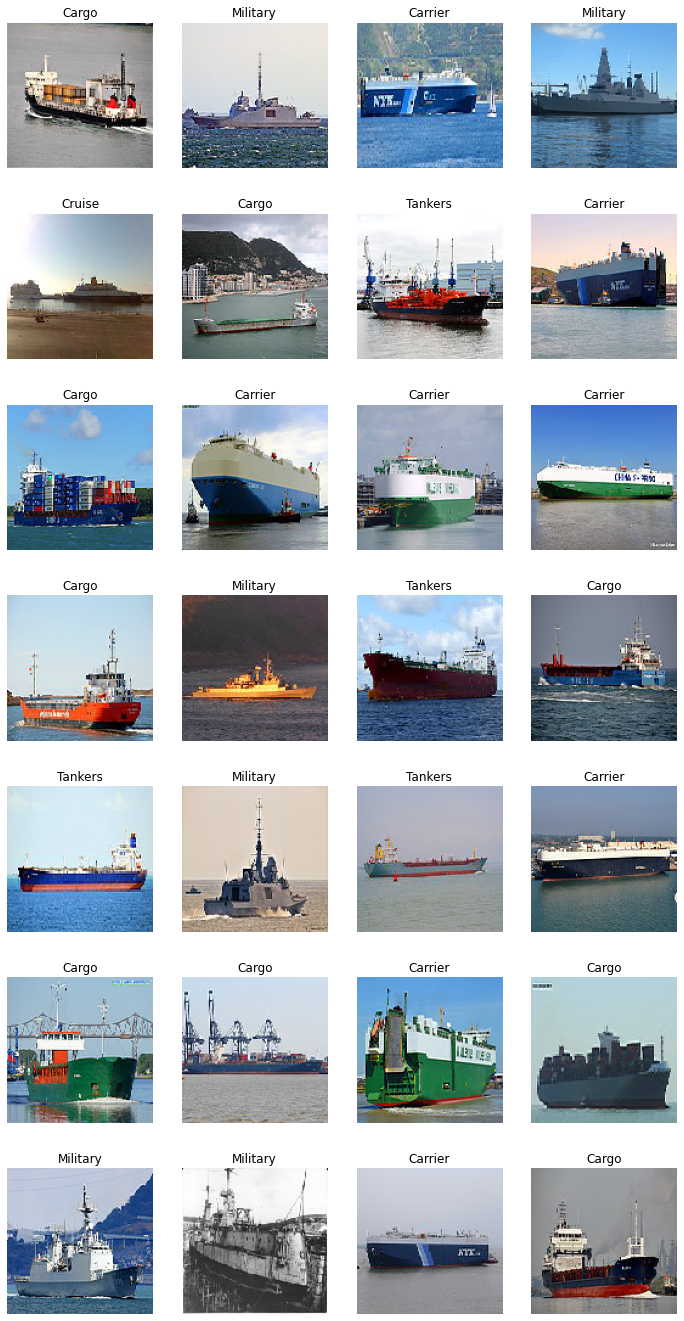

54483

In [15]:
# visualize the top 28 train images
plt.figure(figsize=(12,24))

for i in range(1,29):
    plt.subplot(7,4,i)
    plt.title(f'{train_files["ship"].values[i]}')
    plt.imshow(X_train[i])
    plt.axis('off')
plt.show()
gc.collect()

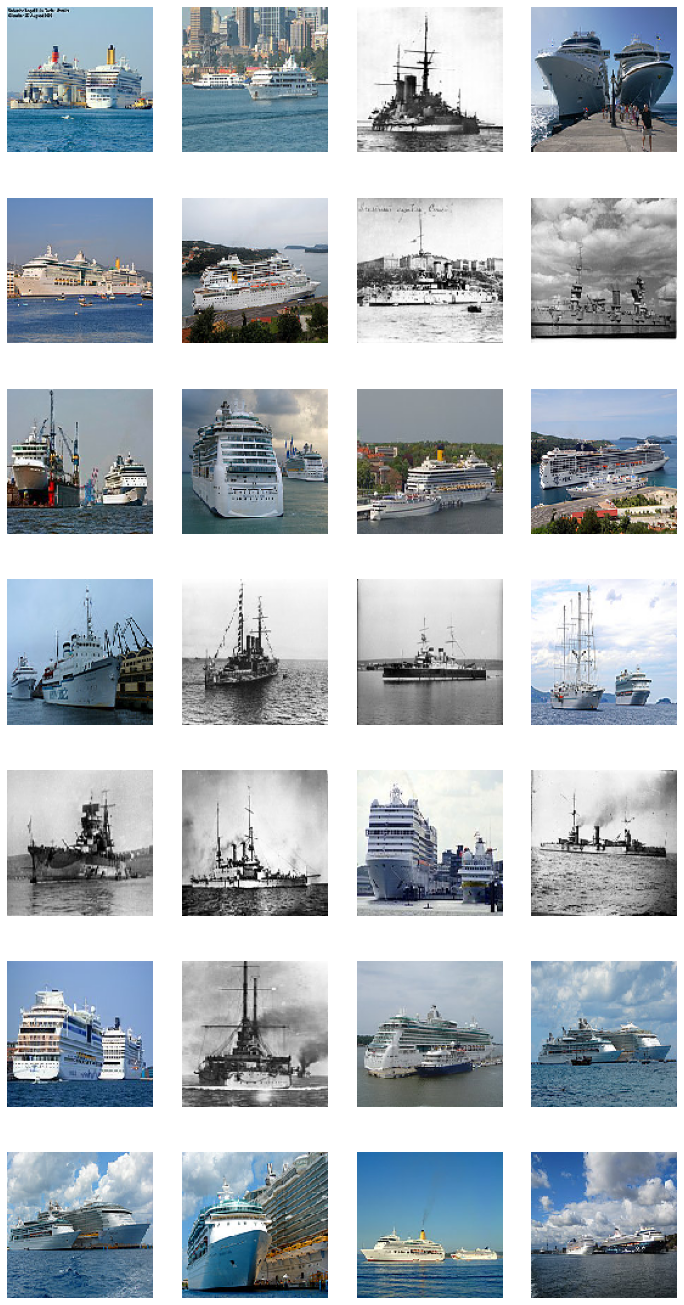

54473

In [16]:
# visualize the top 28 test images
plt.figure(figsize=(12,24))

for i in range(1,29):
    plt.subplot(7,4,i)
    plt.imshow(test[i])
    plt.axis('off')
plt.show()
del test # free up space for training
gc.collect()

In [17]:
ohe = OneHotEncoder(dtype='int8', sparse=False)
y_train = ohe.fit_transform(train_files['category'].values.reshape(-1,1))
print(y_train.shape)
print(X_train.shape)

(6252, 5)
(6252, 120, 120, 3)


In [18]:
#custom callbacks function that calculates f1 score after every epoch to gauge model performance

class printf1(callbacks.Callback):
    def __init__(self, X_train, y_train):
        super(printf1, self).__init__()
        self.bestf1 = 0
        self.X_train = X_train
        self.y_train = y_train
        
    def on_epoch_end(self, epoch, logs={}):
        pred = np.argmax(self.model.predict(np.array(self.X_train)), axis=1)
        f1 = f1_score(np.argmax(self.y_train, axis=1), pred, average='weighted')
        print("Train F1 Score: {:.4f}".format(f1))
        pred = np.argmax(self.model.predict(self.validation_data[0]), axis=1)
        f1 = f1_score(np.argmax(self.validation_data[1], axis=1), pred, average='weighted')
        print("Valid F1 Score: {:.4f}".format(f1))
        return

In [19]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0)

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    gc.collect()

In [20]:
X1_train, X_test, y1_train, y_test = train_test_split(X_train, y_train, 
                                                    stratify=y_train,
                                                    random_state=20,
                                                    test_size=0.2)
                                                   
    
print(X1_train.shape)
print(X_test.shape)
print(y1_train.shape)
print(y_test.shape)

(5001, 120, 120, 3)
(1251, 120, 120, 3)
(5001, 5)
(1251, 5)


In [69]:
#Without Data augmentation
#CNN with relu activation
from keras.constraints import maxnorm
model = Sequential()
model.add(Conv2D(128,3,padding="same", activation="relu", input_shape=(120,120,3)))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(16, 3, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(8, 3, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(256, kernel_constraint=maxnorm(3), activation="relu"))
#model.add(activation="relu")
model.add(Dropout(0.2))
model.add(BatchNormalization())


model.add(Dense(128, kernel_constraint=maxnorm(3), activation="relu"))
#model.add(activation="relu")
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(5, activation="softmax"))
#model.add(Dense(128,activation="relu"))


opt = Adam(lr=0.000001)
model.compile(optimizer = 'adam' , 
              loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 120, 120, 128)     3584      
_________________________________________________________________
batch_normalization_28 (Batc (None, 120, 120, 128)     512       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 60, 60, 128)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 60, 60, 64)        73792     
_________________________________________________________________
batch_normalization_29 (Batc (None, 60, 60, 64)        256       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 30, 30, 32)       

In [70]:
#Without data augmentation
history = model.fit(
                X1_train,y1_train, epochs=15,validation_data = (X_test, y_test))
               

Epoch 1/15
157/157 [==============================] - 361s 2s/step - loss: 1.8637 - accuracy: 0.2396 - val_loss: 1.5462 - val_accuracy: 0.3389
Epoch 2/15
157/157 [==============================] - 340s 2s/step - loss: 1.6267 - accuracy: 0.3113 - val_loss: 1.4934 - val_accuracy: 0.3701
Epoch 3/15
157/157 [==============================] - 289s 2s/step - loss: 1.3550 - accuracy: 0.4131 - val_loss: 1.4894 - val_accuracy: 0.3173
Epoch 4/15
157/157 [==============================] - 300s 2s/step - loss: 1.1897 - accuracy: 0.4927 - val_loss: 1.1726 - val_accuracy: 0.5236
Epoch 5/15
157/157 [==============================] - 347s 2s/step - loss: 1.1068 - accuracy: 0.5301 - val_loss: 1.1983 - val_accuracy: 0.4900
Epoch 6/15
157/157 [==============================] - 314s 2s/step - loss: 1.0014 - accuracy: 0.5761 - val_loss: 0.9359 - val_accuracy: 0.6011
Epoch 7/15
157/157 [==============================] - 297s 2s/step - loss: 0.9618 - accuracy: 0.5921 - val_loss: 1.4979 - val_accuracy: 0.3877

In [71]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [72]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 61.07%


In [96]:
from keras.models import load_model
f1 = printf1(X1_train, y1_train)
cp = ModelCheckpoint('best.hdf5', monitor='val_loss', save_best_only=True)


true = np.argmax(y_test, axis=1)
best = load_model('best.hdf5')
valid_pred_best = np.argmax(best.predict(X_test), axis=1)

#best_f1_score =f1_score(true, valid_pred_best, average="weighted")
#print(f'Best model weighted F1 Score: {best_f1_score:.4f}')

In [78]:
valid_pred = np.argmax(model.predict(X_test), axis=1)
#f1_score = f1_score(true, valid_pred, average="weighted")
#print(f'weighted F1 Score: {f1_score:.4f}')


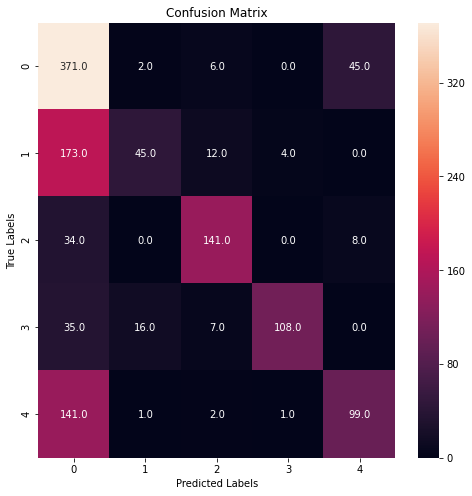

In [79]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predicting labels from X_test data
y_pred = model.predict(X_test)

# Converting prediction classes from one hot encoding to list
# Argmax returns the position of the largest value
y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert test labels from one hot encoding to list
y_test_classes = np.argmax(y_test, axis = 1)

# Create the confusion matrix
confmx = confusion_matrix(y_test_classes, y_pred_classes)
f, ax = plt.subplots(figsize = (8,8))
sns.heatmap(confmx, annot=True, fmt='.1f', ax = ax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show();

In [97]:
labels

['Cargo', 'Cruise', 'Military', 'Carrier', 'Tankers']

In [80]:
print(classification_report(y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.49      0.88      0.63       424
           1       0.70      0.19      0.30       234
           2       0.84      0.77      0.80       183
           3       0.96      0.65      0.77       166
           4       0.65      0.41      0.50       244

    accuracy                           0.61      1251
   macro avg       0.73      0.58      0.60      1251
weighted avg       0.67      0.61      0.59      1251



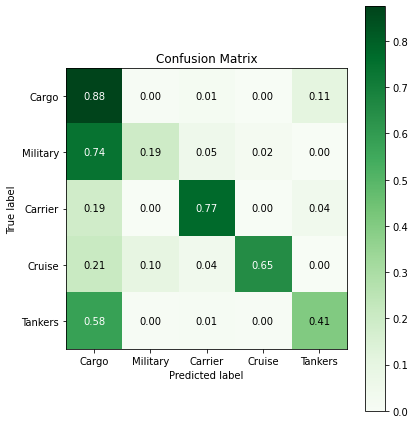

In [82]:
plot_confusion_matrix(true, valid_pred, normalize=True, 
                      classes=labels, title='Confusion Matrix')

In [84]:
test1 = load('test')
sub = pd.read_csv('/Users/susovan/Desktop/springboard doc/ship dataset/sample_submission_ns2btKE.csv')
#if best_f1_score >= f1_score:
    #sub['category'] = np.argmax(best.predict(test1), axis=1) + 1
    
#else:
sub['category'] = np.argmax(model.predict(test1), axis=1) + 1 
    
sub.to_csv('submission.csv', index=False)
sub.head()

100%|██████████| 2680/2680 [00:03<00:00, 783.97it/s]


image  category
0  1007700.jpg         1
1  1011369.jpg         4
2  1051155.jpg         1
3  1062001.jpg         1
4  1069397.jpg         4

In [85]:
sub['category'].map(ship).value_counts(normalize=True)

Cargo       0.588806
Carrier     0.143657
Tankers     0.120522
Cruise      0.087313
Military    0.059701
Name: category, dtype: float64

In [86]:
sub['ship'] = sub['category'].map(ship).astype('category')
print(sub)
labels = list(sub['ship'].unique())
labels

            image  category      ship
0     1007700.jpg         1     Cargo
1     1011369.jpg         4    Cruise
2     1051155.jpg         1     Cargo
3     1062001.jpg         1     Cargo
4     1069397.jpg         4    Cruise
...           ...       ...       ...
2675   950995.jpg         4    Cruise
2676   951046.jpg         4    Cruise
2677   951323.jpg         3   Carrier
2678   952113.jpg         2  Military
2679   953982.jpg         3   Carrier

[2680 rows x 3 columns]


['Cargo', 'Cruise', 'Military', 'Carrier', 'Tankers']

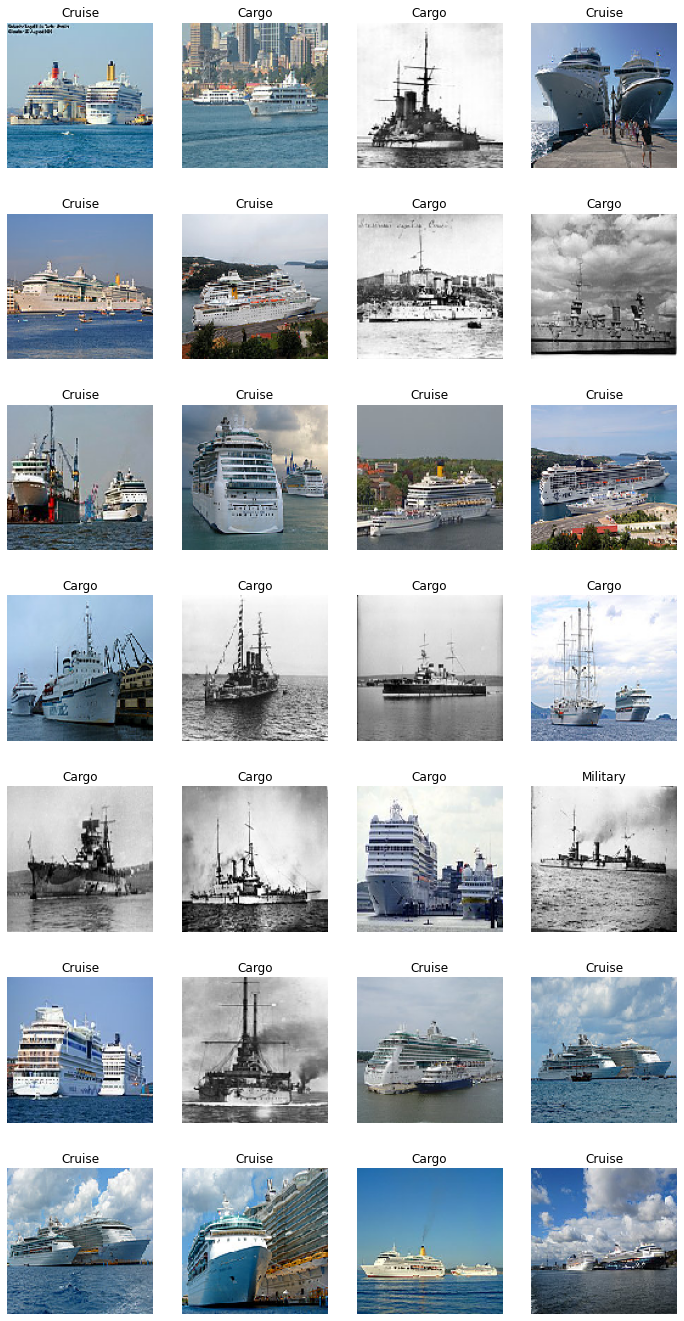

54478

In [87]:
plt.figure(figsize=(12,24))

for i in range(1,29):
    plt.subplot(7,4,i)
    plt.title(f'{sub["ship"].values[i]}')
    plt.imshow(test1[i])
    plt.axis('off')
plt.show()
gc.collect()

In [35]:
#Without Data augmentation
#CNN with sigmoid activation
model = Sequential()
model.add(Conv2D(128, 3, activation = 'sigmoid', padding = 'VALID', input_shape = (120,120,3)))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(64, 3, activation = 'sigmoid', padding = 'VALID', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(32, 3, activation = 'sigmoid', padding = 'VALID', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(32, 3, activation = 'sigmoid', padding = 'VALID', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(16, 3, activation = 'sigmoid', padding = 'VALID', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.4))
#model.add(Conv2D(8, 3, activation = 'sigmoid', padding = 'VALID', kernel_initializer = 'he_uniform'))



model.add(Flatten())
model.add(Dense(128, activation = 'sigmoid', kernel_initializer = 'he_uniform'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(5, activation = 'softmax'))
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(model.summary())
model.save('model.hdf5')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 118, 118, 128)     3584      
_________________________________________________________________
batch_normalization_8 (Batch (None, 118, 118, 128)     512       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 59, 59, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 57, 57, 64)        73792     
_________________________________________________________________
batch_normalization_9 (Batch (None, 57, 57, 64)        256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 26, 26, 32)       

In [36]:

history = model.fit(
                X1_train, y1_train,
                epochs =15,
                validation_data = (X_test, y_test))

Epoch 1/15
157/157 [==============================] - 278s 2s/step - loss: 1.7819 - accuracy: 0.2833 - val_loss: 1.5818 - val_accuracy: 0.3389
Epoch 2/15
157/157 [==============================] - 277s 2s/step - loss: 1.4722 - accuracy: 0.4001 - val_loss: 1.6758 - val_accuracy: 0.3805
Epoch 3/15
157/157 [==============================] - 273s 2s/step - loss: 1.2735 - accuracy: 0.4649 - val_loss: 3.0736 - val_accuracy: 0.1503
Epoch 4/15
157/157 [==============================] - 269s 2s/step - loss: 1.1483 - accuracy: 0.5123 - val_loss: 1.1842 - val_accuracy: 0.5140
Epoch 5/15
157/157 [==============================] - 274s 2s/step - loss: 1.0520 - accuracy: 0.5523 - val_loss: 1.8201 - val_accuracy: 0.3549
Epoch 6/15
157/157 [==============================] - 269s 2s/step - loss: 0.9870 - accuracy: 0.5837 - val_loss: 1.7224 - val_accuracy: 0.4684
Epoch 7/15
157/157 [==============================] - 272s 2s/step - loss: 0.9250 - accuracy: 0.6157 - val_loss: 0.9964 - val_accuracy: 0.5931

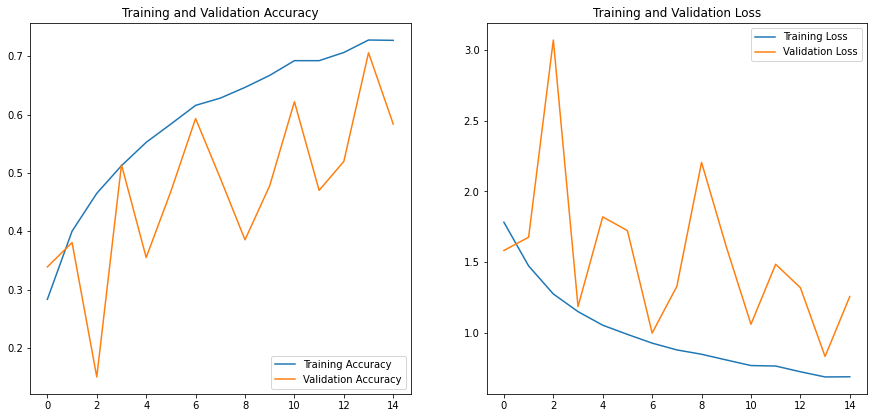

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [38]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 58.35%


In [43]:
from keras.models import load_model
f1 = printf1(X1_train, y1_train)
cp = ModelCheckpoint('best.hdf5', monitor='val_loss', save_best_only=True)


#true = np.argmax(y_test, axis=1)
#best = load_model('best.hdf5')
#valid_pred_best = np.argmax(best.predict(X_test), axis=1)
#best_f1_score = f1_score(true, valid_pred_best, average="weighted")
#print(f'Best model weighted F1 Score: {best_f1_score:.4f}')

In [40]:
valid_pred = np.argmax(model.predict(X_test), axis=1)
f1_score = f1_score(true, valid_pred, average="weighted")
print(f'weighted F1 Score: {f1_score:.4f}')


weighted F1 Score: 0.5832


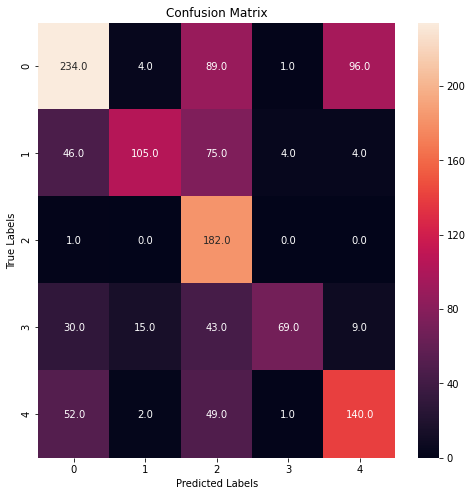

In [41]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predicting labels from X_test data
y_pred = model.predict(X_test)

# Converting prediction classes from one hot encoding to list
# Argmax returns the position of the largest value
y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert test labels from one hot encoding to list
y_test_classes = np.argmax(y_test, axis = 1)

# Create the confusion matrix
confmx = confusion_matrix(y_test_classes, y_pred_classes)
f, ax = plt.subplots(figsize = (8,8))
sns.heatmap(confmx, annot=True, fmt='.1f', ax = ax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show();



In [44]:
print(classification_report(y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.64      0.55      0.59       424
           1       0.83      0.45      0.58       234
           2       0.42      0.99      0.59       183
           3       0.92      0.42      0.57       166
           4       0.56      0.57      0.57       244

    accuracy                           0.58      1251
   macro avg       0.68      0.60      0.58      1251
weighted avg       0.67      0.58      0.58      1251



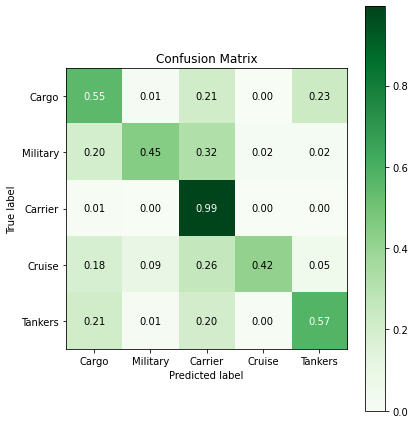

In [45]:
plot_confusion_matrix(true, valid_pred, normalize=True, 
                      classes=labels, title='Confusion Matrix')

In [ ]:
test1 = load('test')
sub = pd.read_csv('/Users/susovan/Desktop/springboard doc/ship dataset/sample_submission_ns2btKE.csv')
if best_f1_score >= f1_score:
    sub['category'] = np.argmax(best.predict(test1), axis=1) + 1
    
else:
    sub['category'] = np.argmax(model.predict(test1), axis=1) + 1 
    
sub.to_csv('submission.csv', index=False)
sub.head()

In [ ]:
sub['category'].map(ship).value_counts(normalize=True)

In [ ]:
sub['ship'] = sub['category'].map(ship).astype('category')
print(sub)
labels = list(sub['ship'].unique())
labels

In [ ]:
plt.figure(figsize=(12,24))

for i in range(1,29):
    plt.subplot(7,4,i)
    plt.title(f'{sub["ship"].values[i]}')
    plt.imshow(test1[i])
    plt.axis('off')
plt.show()
gc.collect()

In [46]:
#Data augmentation
batch_size = 100
epochs = 15
datagen = ImageDataGenerator(rotation_range=40,
                             horizontal_flip=True, 
                             width_shift_range=0.5, 
                             height_shift_range=0.5, 
                             zoom_range=[0.5,0.5],
                             dtype='float32')




datagen.fit(X_train, augment=True, rounds=1, seed=20)
train_generator = datagen.flow(X1_train, y1_train, 
                               batch_size=batch_size, 
                               seed=20)
            



In [47]:
#With Data augmentation
#CNN with relu activation
from keras.constraints import maxnorm
model = Sequential()
model.add(Conv2D(128,3,padding="same", activation="relu", input_shape=(120,120,3)))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(16, 3, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(8, 3, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(256, kernel_constraint=maxnorm(3), activation="relu"))
#model.add(activation="relu")
model.add(Dropout(0.2))
model.add(BatchNormalization())


model.add(Dense(128, kernel_constraint=maxnorm(3), activation="relu"))
#model.add(activation="relu")
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(5, activation="softmax"))
#model.add(Dense(128,activation="relu"))


opt = Adam(lr=0.000001)
model.compile(optimizer = 'adam' , 
              loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 120, 120, 128)     3584      
_________________________________________________________________
batch_normalization_14 (Batc (None, 120, 120, 128)     512       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 60, 60, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 60, 60, 64)        73792     
_________________________________________________________________
batch_normalization_15 (Batc (None, 60, 60, 64)        256       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 30, 30, 32)       

In [48]:
#With Data augmentation
history = model.fit_generator(train_generator,
                              epochs = epochs,
                              validation_data = (X_test, y_test)
                              )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
51/51 [==============================] - 381s 7s/step - loss: 1.9768 - accuracy: 0.2180 - val_loss: 1.5611 - val_accuracy: 0.3389
Epoch 2/15
51/51 [==============================] - 318s 6s/step - loss: 1.7953 - accuracy: 0.2456 - val_loss: 1.5701 - val_accuracy: 0.3381
Epoch 3/15
51/51 [==============================] - 313s 6s/step - loss: 1.7155 - accuracy: 0.2773 - val_loss: 1.5760 - val_accuracy: 0.3317
Epoch 4/15
51/51 [==============================] - 338s 7s/step - loss: 1.6519 - accuracy: 0.2905 - val_loss: 1.5735 - val_accuracy: 0.3349
Epoch 5/15
51/51 [==============================] - 331s 6s/step - loss: 1.6264 - accuracy: 0.2865 - val_loss: 1.5529 - val_accuracy: 0.3389
Epoch 6/15
51/51 [==============================] - 358s 7s/step - loss: 1.5785 - accuracy: 0.3013 - val_loss: 1.5032 - val_accuracy: 0.3509
Epoch 7/15
51/51 [==============================] - 297s 6s/step - loss: 1.571

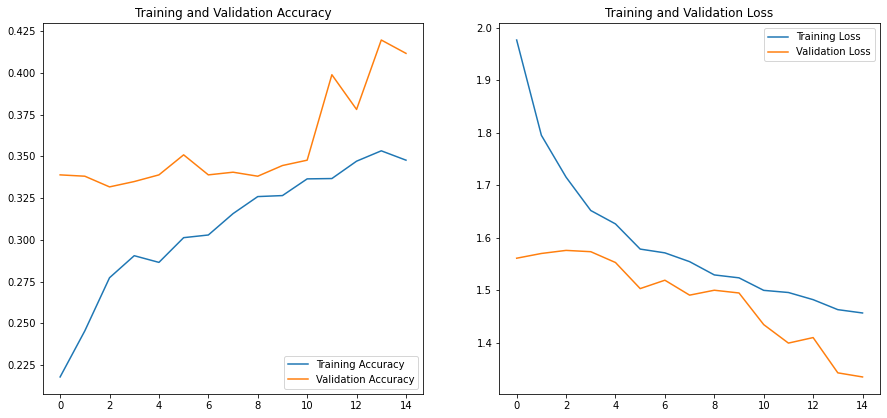

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [50]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


Accuracy: 41.17%


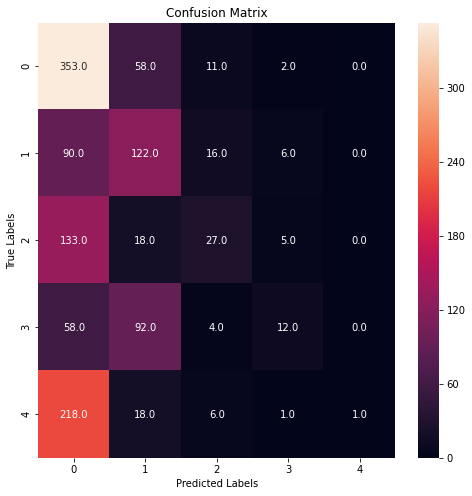

In [55]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predicting labels from X_test data
y_pred = model.predict(X_test)

# Converting prediction classes from one hot encoding to list
# Argmax returns the position of the largest value
y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert test labels from one hot encoding to list
y_test_classes = np.argmax(y_test, axis = 1)

# Create the confusion matrix
confmx = confusion_matrix(y_test_classes, y_pred_classes)
f, ax = plt.subplots(figsize = (8,8))
sns.heatmap(confmx, annot=True, fmt='.1f', ax = ax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show();

In [56]:
print(classification_report(y_test_classes, y_pred_classes))


              precision    recall  f1-score   support

           0       0.41      0.83      0.55       424
           1       0.40      0.52      0.45       234
           2       0.42      0.15      0.22       183
           3       0.46      0.07      0.12       166
           4       1.00      0.00      0.01       244

    accuracy                           0.41      1251
   macro avg       0.54      0.32      0.27      1251
weighted avg       0.53      0.41      0.32      1251



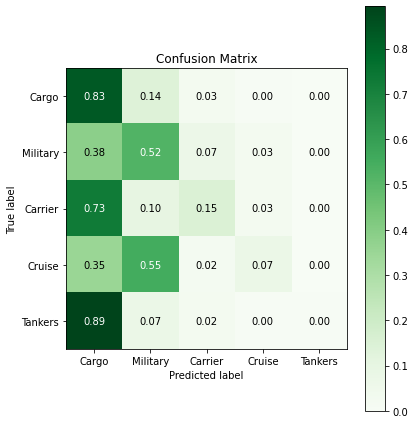

In [57]:
plot_confusion_matrix(true, valid_pred, normalize=True, 
                      classes=labels, title='Confusion Matrix')

In [59]:
#With Data augmentation
#CNN with sigmoid activation
model = Sequential()
model.add(Conv2D(128, 3, activation = 'sigmoid', padding = 'VALID', input_shape = (120,120,3)))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(64, 3, activation = 'sigmoid', padding = 'VALID', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(32, 3, activation = 'sigmoid', padding = 'VALID', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(32, 3, activation = 'sigmoid', padding = 'VALID', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(16, 3, activation = 'sigmoid', padding = 'VALID', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.4))
#model.add(Conv2D(8, 3, activation = 'sigmoid', padding = 'VALID', kernel_initializer = 'he_uniform'))



model.add(Flatten())
model.add(Dense(128, activation = 'sigmoid', kernel_initializer = 'he_uniform'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(5, activation = 'softmax'))
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(model.summary())
model.save('model1.hdf5')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 118, 118, 128)     3584      
_________________________________________________________________
batch_normalization_22 (Batc (None, 118, 118, 128)     512       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 59, 59, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 57, 57, 64)        73792     
_________________________________________________________________
batch_normalization_23 (Batc (None, 57, 57, 64)        256       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 26, 26, 32)       

In [60]:
#With Data augmentation
history = model.fit_generator(train_generator,
                              epochs = epochs,
                              validation_data = (X_test, y_test)
                              )

Epoch 1/15
51/51 [==============================] - 299s 6s/step - loss: 1.9302 - accuracy: 0.2284 - val_loss: 1.5866 - val_accuracy: 0.3389
Epoch 2/15
51/51 [==============================] - 364s 7s/step - loss: 1.8205 - accuracy: 0.2336 - val_loss: 1.5676 - val_accuracy: 0.3389
Epoch 3/15
51/51 [==============================] - 317s 6s/step - loss: 1.7431 - accuracy: 0.2555 - val_loss: 1.5551 - val_accuracy: 0.3389
Epoch 4/15
51/51 [==============================] - 332s 7s/step - loss: 1.7088 - accuracy: 0.2639 - val_loss: 1.5500 - val_accuracy: 0.3389
Epoch 5/15
51/51 [==============================] - 307s 6s/step - loss: 1.6724 - accuracy: 0.2725 - val_loss: 1.5463 - val_accuracy: 0.3389
Epoch 6/15
51/51 [==============================] - 317s 6s/step - loss: 1.6536 - accuracy: 0.2731 - val_loss: 1.5516 - val_accuracy: 0.3389
Epoch 7/15
51/51 [==============================] - 392s 8s/step - loss: 1.6338 - accuracy: 0.2777 - val_loss: 1.5482 - val_accuracy: 0.3389
Epoch 8/15
51

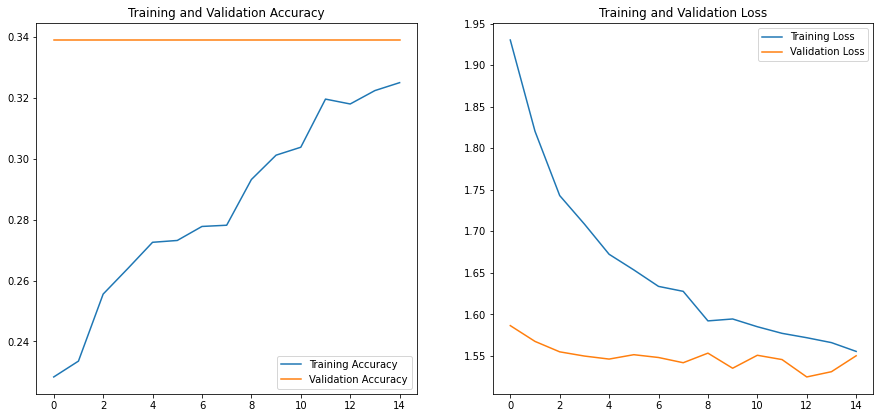

In [61]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [62]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 33.89%


In [63]:
from keras.models import load_model
f1 = printf1(X1_train, y1_train)
cp = ModelCheckpoint('best.hdf5', monitor='val_loss', save_best_only=True)


In [65]:
#valid_pred = np.argmax(model.predict(X_test), axis=1)
#f1_score = f1_score(true, valid_pred, average="weighted")
#print(f'weighted F1 Score: {f1_score:.4f}')


In [66]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predicting labels from X_test data
y_pred = model.predict(X_test)

# Converting prediction classes from one hot encoding to list
# Argmax returns the position of the largest value
y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert test labels from one hot encoding to list
y_test_classes = np.argmax(y_test, axis = 1)

# Create the confusion matrix
confmx = confusion_matrix(y_test_classes, y_pred_classes)
f, ax = plt.subplots(figsize = (8,8))
sns.heatmap(confmx, annot=True, fmt='.1f', ax = ax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show();

In [67]:
print(classification_report(y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.34      1.00      0.51       424
           1       0.00      0.00      0.00       234
           2       0.00      0.00      0.00       183
           3       0.00      0.00      0.00       166
           4       0.00      0.00      0.00       244

    accuracy                           0.34      1251
   macro avg       0.07      0.20      0.10      1251
weighted avg       0.11      0.34      0.17      1251



In [68]:
plot_confusion_matrix(true, valid_pred, normalize=True, 
                      classes=labels, title='Confusion Matrix')